# MADE (Masked Autoencoders for Distribution Estimation)

Below is an implementation of [MADE](https://arxiv.org/abs/1502.03509). Like an autoencoder, this network tries to recreate the input. Unlike an autoencoder, it has a significant constraint: each pixel is only allowed to depend on the pixels that come before it. This means the second pixel depends only on the first, the third on the first and second, and so on. This is described in the paper by saying $x_d = f(x_{<d})$, where $x_{<d} = (x_1, x_2, \dots, x_{d-1})$. This is called the *autoregressive property*, tying it to [autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_model).

The way this property is achieved in the model is by selectively masking weights to hide inputs and connections. Normally, the linear layer is $b+Ax$, where $b$ is the bias, $A$ is a learned matrix and $x$ is the input. For MADE, we also have a mask matrix $M$, which has only $0$s and $1$S, and use $b+(M\odot A)x$. (The operator $\odot$ is pointwise multiplication.) The mask construction is detailed in the paper. The important fact is that the masks are constructed in order to force the autoregressive property.

The implementation of MADE here includes most of the features mentioned in the paper, including:
* Mask recycling. To avoid the computational work of generating a mask for every batch, we instead generate the masks at creation and cycle through them. This effectively limits us to a few specific masks. In the paper, they note that more than 64 masks tends to degrade performance. In the implementation below, I store the seeds used to create the masks as part of the model. This allows us to regenerate the masks when we reload the model. We could also store the masks, but this would the size of the model would then grow directly proportional to the number of masks.
* Dynamic masks. In this situation, we change the mask every batch. It's worth noting that there is an implicit bound on the number of masks (as there are only so many mask matrices that can be chosen), and so there is a (large) finite number of masks. As noted above, this suffers from performance issues, which I have now seen for myself.
* Direct connection layer. If we are using a deep MADE model, then this serves as a shortcut layer. This is a layer separate from the deep network that takes in the input, feeds it through this layer, and then combines it with the result of the second-to-last layer of the deep network. This combined result is then fed into the last layer. Normally, the output of the last layer would be $f(b_{n}+(M_{n}\odot A_{n})x_{n-1})$. With a direct connection layer, the output becomes $f(b_{n}+(M_{n}\odot A_{n})x_{n-1}+L x_0)$, where $L$ is a strictly lower triangular matrix that serves as the direct connection. The strictly lower triangularity is necessary to keep the autoregressive property.
* Mask weights. These are weights that serves as a bias on the assigned mask. Rather than using $b+(M\odot A)x$ as above, we use $b+(M\odot A)x + (M \odot Q)\mathbf{1}$, where $Q$ is the mask weight and $\mathbf{1}$ is a vector with $1$ for every entry. In effect, $Q$ should serve to stabilize the bias $b$ against changes that might occur from changing the mask. It's worth noting that $Q$ is necessarily the same size as $A$ in this formulation, and so it has drastic impacts on the size of the model. It also didn't seem to have positive effects on the image reconstructions, so I have left it to be false. A less memory intense version would be to use $Mq$ instead of $(M \odot Q)\mathbf{1}$, where $q$ is a vector instead. In this situation, $q$ would have `in_features` parameters, while $Q$ has `(in_features)*(out_features)` parameters. I haven't had a chance to determine if this is effective.
* 'Conditional' or 'deterministic' inputs. This isn't mentioned in the paper, but I included it so that I can have an extra deterministic parameter be used as part of the input. These are not masked, and are meant to transmit high level information that will be used in the reconstruction. In a basic use case, we could provide as input a tensor holding the values for an image, and a label of the image.

## Code
### MADE

In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np

In [2]:
class MaskedLinear(nn.Linear):
    '''
    Defines a masked linear layer by adding a feature mask. The mask is multiplied (element-wise) with
    the linear weights to selectively zero out features. 
    
    :param in_features: (int)
    :param out_features: (int)
    :param mask_conditioning: (bool)
    :param bias: (bool)
    '''
    def __init__(self, in_features, out_features, mask_conditioning=False, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask = t.ones_like(self.weight)
        if mask_conditioning:
            self.mask_weight = nn.Parameter(t.Tensor(out_features, in_features))
            nn.init.kaiming_uniform_(self.mask_weight, a=np.sqrt(5))
        else:
            self.register_parameter('mask_weight', None)
            
    def set_mask(self, new_mask):
        assert new_mask.T.shape == self.weight.shape, \
            'Mask needs to be the same shape as weight, but recieved {0} and {1}'.format(new_mask.shape, self.weight.shape)
        self.mask = t.tensor(new_mask.T, dtype=self.weight.dtype, device=self.weight.device)
            
    def forward(self, input):
        mask = self.mask.to(device=input.device)
        x = F.linear(input, mask*self.weight, self.bias)
        if self.mask_weight is not None:
            x += F.linear(t.ones_like(input), mask*self.mask_weight)
        return x

In [3]:
class MADE(nn.Module):
    '''
    Defines a masked autoencoder using masked linear layers. 
    
    :params layer_widths: [int], widths of each layer. The first entry should be
        the input size. The last entry should be the output size. It is expected that
        the output size is a multiple of the input size. If this is not possible,
        consider setting some of the input variables to conditions.
    :params num_masks: (int, optional) The number of masks to use. If set to 0, then
        we generate a new mask every call during training. Otherwise, we generate
        a fixed number of masks to cycle through during training.
    :params in_conditions: (int, opt) Size of the variable $c$ to condition the 
        input on. If 0, then the model recreates x with no additional input. 
        Otherwise, the model expects an additional input c to be used for recreating
        x. To clarify, if in_conditions = 0, then we construct p(x). Otherwise, we
        construct p(x|c).
    :params connectivity_agnostic: (Bool, opt) When true, every mask will have
        a different connectivity. Otherwise, every mask uses the same connectivity.
    :params order_agnostic: (Bool, opt) When true, each mask will have a
        randomized ordering of inputs. Otherwise, the original ordering of the input
        vector is used.
    :params direct_connection: (Bool, opt) When true, the final output will be adjusted
        using an extra weight matrix. In order to satisfy the autoregressive property,
        the weight matrix is strictly lower triangular.
    :params mask_conditioning: (Bool, opt) When true, each MaskedLinear layer will also
        create a mask conditioning weight matrix. This weight matrix adjusts the output
        of the layer depending on the mask. Otherwise, the layer will be a simple
        masked linear layer. See MaskedLinear for more detail.
    :params seeds: ([int], opt) Sets the seed used to generate the masks. These are
        used to recreate the masks when the model is reloaded so that the masks
        themselves do not have to be saved.
    '''
    def __init__(self, 
                 layer_widths, 
                 num_masks=1,
                 in_conditions=0,
                 connectivity_agnostic=True, 
                 order_agnostic=True,
                 direct_connection=False,
                 mask_conditioning=False,
                 seeds=None):
        assert (layer_widths[-1] % layer_widths[0]) == 0, \
            'layer_width[-1] should be a multiple of layer_width[0].'
        super(MADE, self).__init__()
        #Save parameters
        self.in_features = layer_widths[0]
        self.in_conditions = in_conditions
        self.out_features = layer_widths[-1]
        self.num_masks = num_masks        
        self.connectivity_agnostic = connectivity_agnostic
        self.order_agnostic = order_agnostic
        #Store seeds used to create masks - this is more space efficient than storing the
        #masks themselves, as each mask is as large as the weight matrix.
        if num_masks > 0:
            assert (seeds is None) or (len(seeds) == len(num_masks)), \
                'If seeds are specified, there should be a seed for every mask.'
            if seeds is None:
                seeds = np.frombuffer(np.random.bytes(8*num_masks), dtype='uint32')
                seeds = t.from_numpy(seeds.astype('int64'))
        else:
            seeds = None
        self.register_buffer('mask_seeds', seeds)
        self.mask_idx = 0
        
        ## Construct feedforward network.
        #get sizes
        input_sizes, output_sizes = layer_widths[:-1], layer_widths[1:]
        #Add number of conditions if used
        input_sizes[0] += in_conditions
        #make layers
        layers = [MaskedLinear(s_in, s_out, mask_conditioning) for s_in, s_out in zip(input_sizes, output_sizes)]
        self.layers = nn.ModuleList(layers)
        #Add direct connection layer
        if direct_connection:
            self.direct = nn.Parameter(t.Tensor(layer_widths[0], layer_widths[-1]))
            nn.init.kaiming_uniform_(self.direct, a=np.sqrt(5))
        else:
            self.register_parameter('direct', None)

        #Generate the connectivity of the masks.
        if not self.connectivity_agnostic:
            #Reproducibility - if seeds are set, use first seed to generate the connectivity
            #for all.
            if seeds is not None:
                seed = seeds[0]
            else:
                seed = None
                
            #If not agnostic, then use the same connectivity for all
            self.connectivity = self.generate_connectivity(seed)
        else:
            #Otherwise, use a different one for each mask.
            self.connectivity = None
            
        #Generate masks
        if num_masks > 0:
            masks = self.generate_masks()
        else:
            #If num_masks is negative, generate a new mask for every
            #pass.
            masks = None
        self.masks = masks
        
    def generate_masks(self):
        masks_list = []
        for idx in range(self.num_masks):
            layer_masks = self.generate_layer_masks(self.mask_seeds[idx])
            masks_list.append(layer_masks)
        return masks_list
    
    def generate_connectivity(self, seed=None):
        rng = np.random.RandomState(seed)
        connectivity = [rng.randint(1, self.in_features, size=self.layers[0].out_features)]
        for layer in self.layers[1:]:
            layer_connectivity = rng.randint(connectivity[-1].min(), self.in_features, size=layer.out_features)
            connectivity.append(layer_connectivity)
        return connectivity

    def generate_layer_masks(self, seed=None):
        rng = np.random.RandomState(seed)
        m = [np.arange(self.in_features)]
        #If it's order agnostic, we shuffle the input order.
        if self.order_agnostic:
            rng.shuffle(m[0])

        #If it's connection agnostic, we change the connectivity.
        if self.connectivity_agnostic:
            connectivity = self.generate_connectivity(seed)
        else:
            connectivity = self.connectivity
        m.extend(connectivity)

        # construct the mask matrices
        L = len(self.layers)
        masks = [m[index][:,None] <= m[index+1][None,:] for index in range(L)]
        masks.append(m[L][:,None] < m[0][None,:])
        #First mask needs to be fixed for conditioned data
        if self.in_conditions > 0:
            extra_connections = np.ones((self.in_conditions, self.layers[0].out_features))
            masks[0] = np.concatenate([masks[0], extra_connections], 0)
        return masks
    
    def next_mask(self):
        if self.num_masks == 1:
            #We don't need to change the mask
            return
        elif self.num_masks == 0:
            masks = self.generate_layer_masks()
        else:
            self.mask_idx = (self.mask_idx+1) % self.num_masks
            masks = self.masks[self.mask_idx]
        
        for layer, mask in zip(self.layers, masks):
            layer.set_mask(mask)
    
    def forward(self, input, condition=None):
        '''
        Does a forward pass.
        
        :param input: (t.Tensor)
        :param condition: (t.Tensor)
        '''
        if condition is not None:
            assert self.in_conditions == condition.shape[1], \
                'Expected {} conditions, but recieved condition of size {}'.format(self.in_conditions, condition.shape[1:])
            x = t.cat([input, condition], 1)
        else:
            assert self.in_conditions == 0, 'This model does not use a conditioning variable.'
            x = input

        if self.training:
            self.next_mask()

        for layer in self.layers[:-1]:
            x = F.selu(layer(x))
        x = self.layers[-1](x)
        if self.direct is not None:
            #We use an additional weight matrix to augment the final output.
            #The matrix must be strictly lower triangular in order to satisfy
            #the autoregressive property.
            x += F.linear(input, self.direct.tril(-1))
        return x

    def ensemble(self, input, condition=None, votes=None, reduction='none'):
        '''
        Run forward on each input, condition using different masks. The number
        of votes cannot be more than the number of masks. If reduction is 'none',
        then each mask will return an output. If it is 'mean', then only the
        mean of the votes will be returned.
        
        This is useful for viewing reconstructions by the model, as the mean
        reconstruction is typically more accurate.
        :param input: (t.Tensor)
        :param condition: (t.Tensor)
        :param votes: (Int, opt) Number of different masks to cycle through
        :param reduction: (Str, opt) Whether to return each vote or the
            average vote.
        '''
        votes = votes or self.num_masks
        assert votes > 0, 'Votes should be a positive integer.'
        assert (votes <= self.num_masks) or (self.num_masks == 0), \
            'Votes cannot be more than the number of masks ({}).'.format(self.num_masks)
        prediction = t.zeros((votes,) + input.shape, device=input.device)
        for idx in range(votes):
            self.next_mask()
            prediction[idx,:] = t.sigmoid(self.forward(input, condition))
        if reduction == 'mean':
            return prediction.mean(0)
        else:
            return prediction
        
    def unmask(self):
        '''
        sets all masks to be identically 1, effectively removing all masks.
        '''
        for layer in self.layers:
            mask_shape = layer.weight.shape
            layer.set_mask(np.ones(mask_shape).T)

### Training setup

Training is done using pytorch lightning.

In [4]:
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pytorch_lightning as pl

In [5]:
class MADE_system(pl.LightningModule):
    def __init__(self, model, batch_size=128):
        super(MADE_system, self).__init__()
        self.net = model
        self.batch_size = batch_size

    def forward(self, x):
        return self.net.forward(x)

    def training_step(self, batch, batch_nb):
        x, y = batch
        x = x.view((-1, 28**2))
        x_hat = self.forward(x)
        
        loss = BCELoss(x_hat, x)
        
        self.net.next_mask()
        return {'loss': loss}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        x = x.view((-1, 28**2))
        x_hat = self.forward(x)
        
        loss = BCELoss(x_hat, x)
        
        self.net.next_mask()
        return {'loss': loss}

    def validation_end(self, outputs):
        # OPTIONAL
        avg_loss = t.stack([x['loss'] for x in outputs]).mean()
        return {'avg_loss': avg_loss}

    def configure_optimizers(self):
        # Same optimizer used in tf implementation
        return t.optim.AdamW(self.net.parameters(), lr=0.001)

    @pl.data_loader
    def tng_dataloader(self):
        #Set up training data. We use these to optimize our network.
        dset = datasets.MNIST(root='./', train=True, download=False, transform=transforms.ToTensor())
        training_set = data.Subset(dset, range(50000))
        return data.DataLoader(training_set, batch_size=self.batch_size, num_workers=4)

    @pl.data_loader
    def val_dataloader(self):
        #Set up validation data. We use the last 10k for training. These are never used for optimization.
        dset = datasets.MNIST(root='./', train=True, download=False, transform=transforms.ToTensor())
        testing_set = data.Subset(dset, range(50000+1,60000))
        return data.DataLoader(testing_set, batch_size=self.batch_size)

In [6]:
def BCELoss(input, target):
    #Implements binary cross entropy with logits that takes a batch average.
    loss = F.binary_cross_entropy_with_logits(input, target)
    loss = loss.mean(0)
    return loss.sum()

### Training

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [8]:
checkpoint_callback = ModelCheckpoint(
    filepath='./models/MADE',
    save_best_only=True,
    verbose=True,
    monitor='avg_loss',
    mode='min',
)

In [9]:
layer_widths = [28**2,] + [1000]*2 + [28**2,]
num_masks = 64
model = MADE(layer_widths, num_masks, direct_connection=True, mask_conditioning=False)

In [10]:
model.load_state_dict(t.load('./models/MADE.pkl', map_location='cpu'))

<All keys matched successfully>

## Image Reconstruction

Below I show off some image reconstructions. This is because it's an effective (and pleasing) way to see what their results.

### Ensemble Reconstruction
The reconstructions performed by the MADE model using a single mask tend to be fairly noisy. This makes sense when you consider the impact of the autoregressive property. As each pixel can only depend on prior pixels, we run into an issue with the first pixel. Specifically, there is no input from the image for deciding that pixel. For any image, the first pixel will be the same. Due to the random connectivity and ordering used in training, the 'first pixel' is usually multiple pixels that get distributed around the image.

To reduce the effects of noise, we can use ensembles to reconstruct an image. In this case, the ensemble is formed by running the image through the model for multiple masks. This is expensive, as it requires passing through the batch once for each mask. The result is more accurate since the initial noise from the model is diminished by taking the average. However, the ensemble will typically not be autoregressive.

In [11]:
import matplotlib.pylab as plt

In [12]:
def image_plot(axis, image, **kwargs):
    axis.imshow(image.view(28,28), cmap='Greys', **kwargs)

In [13]:
n_images = 6

images = datasets.MNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
test_loader = data.DataLoader(images, batch_size=n_images)
samples = next(iter(test_loader))

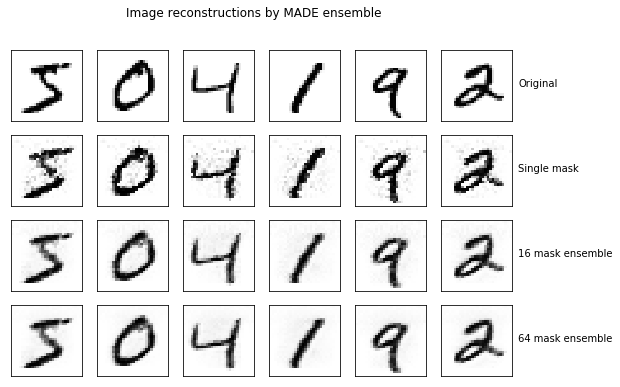

In [14]:
#Set up picture
ax_settings = {'aspect':'equal', 'xticklabels':[], 'yticklabels':[], 'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(4, n_images, subplot_kw=ax_settings, figsize=(n_images*3//2, 6))


if num_masks == 0:
    votes = 16
else:
    votes = num_masks

model.cpu()
model.eval()
with t.no_grad():
    images, _ = samples
    images = images.view((n_images, 28**2))

    recons = model.ensemble(images, votes=votes, reduction='none')


    #Find the mean in latent space
    for idx in range(n_images):
        image_plot(ax[0, idx], images[idx, :])
        image_plot(ax[1, idx], recons[0, idx, :])
        image_plot(ax[2, idx], recons[:votes//4, idx, :].mean(0))
        image_plot(ax[3, idx], recons[:, idx, :].mean(0))

ax[0,-1].text(30.0, 14, 'Original')
ax[1,-1].text(30.0, 14, 'Single mask')
ax[2,-1].text(30.0, 14, '{} mask ensemble'.format(votes//4))
ax[3,-1].text(30.0, 14, '{} mask ensemble'.format(votes))
fig.suptitle('Image reconstructions by MADE ensemble')
plt.savefig('./images/MADE-ensemble-reconstructions.png', bbox_inches='tight')

### Unmasked Reconstruction

I was curious about was the result of unmasking each layer. Doing a forward pass at this point no longer satisfies the autoregressive property, but I was interested in seeing the result. What I expected is that it would produce images between a single mask and an ensemble. The result achieved is below. While the reconstruction is recognized, the noise is still significant and the character strokes are broader. I tested the result after changing the number of masks. I had originally expected that removing the explicit bound would reduce the noise, but it made for significantly worse results. Similarly, using very few masks also produces poor results after unmasking.

The image below is created by unmasking a 64 mask MADE model.

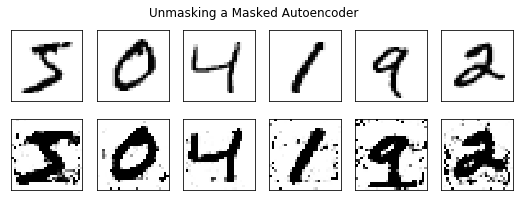

In [15]:
model.unmask()
#Set up picture
ax_settings = {'aspect':'equal', 'xticklabels':[], 'yticklabels':[], 'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(2, n_images, subplot_kw=ax_settings, figsize=(n_images*3//2, 3))

with t.no_grad():

    recons = model(images)
    #Find the mean in latent space
    for idx in range(n_images):
        image_plot(ax[0, idx], images[idx, :])
        image_plot(ax[1, idx], t.sigmoid(recons[idx, :,]))
fig.suptitle('Unmasking a Masked Autoencoder')
plt.savefig('./images/MADE-unmasked-reconstructions.png')

## Final Comments

The reason I am interested in MADE is due to a paper on [Inverse Autoregressive Flow](https://arxiv.org/abs/1606.04934v2). The takeaway I want to emphasize is that a MADE network can be attached to a variational autoencoder in order to give it access to more flexible distributions. The autoregressive property is key to the loss estimate used for the latent variables. This is also why I add the conditional/deterministic input.